In [5]:
import lib.matnpy.matnpy as matnpy
import lib.matnpy.matnpyio as io
import lib.matnpy.preprocess as pp
import matplotlib.pyplot as plt

In [6]:
from scipy import signal
import numpy as np
import scipy.fftpack

In [7]:
import os

In [8]:
def get_cut_from_raw(sess_no, raw_path, align_on, from_time, to_time) :
    """Gets raw data and preprocess them.
    
    Args:
        sess_no: A str. num of the session
        raw_path: A str. Path to the trial_info file.
        align_on: A str. One of 'sample' , 'match'.
        from_time : A float. in ms
        to_time :  A float. in ms. cuts the trial between from_time and to_time. 0 correspond at the onset time of align_on.
        
        
    Returns:
        Ndarray of filtered data. 
    """
    
    #params
    sess = '01'
       
    trial_length = abs(from_time - to_time)

    # Paths
    #raw_path = base_path + 'data/raw/' + sess_no + '/session' + sess + '/'
    rinfo_path = raw_path + 'recording_info.mat'
    tinfo_path = raw_path + 'trial_info.mat'

    # Define and loop over intervals
    
    srate = io.get_sfreq(rinfo_path) # = 1 000
    n_trials = io.get_number_of_trials(tinfo_path) 
    last_trial = int(max(io.get_trial_ids(raw_path)))
    n_chans = io.get_number_of_channels(rinfo_path)
    channels = [ch for ch in range(n_chans)]

    # Pre-process data
    filtered = np.empty([n_trials,
                        len(channels),
                        int(trial_length * srate/1000)])

    trial_counter = 0; counter = 0
    while trial_counter < last_trial:
        n_zeros = 4-len(str(trial_counter+1))
        trial_str = '0' * n_zeros + str(trial_counter+1)  # fills leading 0s
        if sess == '01' :
            file_in = sess_no + '01.' + trial_str + '.mat'
        else :
            file_in = sess_no + '02.' + trial_str + '.mat'
            
        if align_on == 'sample' :        
            onset = io.get_sample_on(tinfo_path)[trial_counter].item()
        elif align_on == 'match' :
            onset = io.get_match_on(tinfo_path)[trial_counter].item()
        else :
            print("Petit problème avec align_on : 'sample' ou 'match' ")
            

        
        if np.isnan(onset):  # drop trials for which there is no onset info
            print('No onset for ' + file_in)
            trial_counter += 1
            if trial_counter == last_trial:
                break
            else:
                counter += 1
                continue
        print(file_in)
        try:
            raw = io.get_data(raw_path + file_in)
            temp = pp.strip_data(raw,
                                rinfo_path,
                                onset,
                                start=from_time,
                                length=trial_length)
            if temp.shape[1] == trial_length:  # drop trials shorter than length
                filtered[counter] = temp
            counter += 1
        except IOError:
            print('No file ' + file_in)
        trial_counter += 1

    # Return data

    filtered = np.array(filtered)
    return(filtered)

# raw path

In [9]:
raw_path = '/media/rudy/disk2/lucy/' 
#raw_path = '/home/rudy/ethyl/'

In [10]:
# for lucy
session = os.listdir(raw_path)
session.remove('unique_recordings.mat')
print(session)

# for ethyl
# session = os.listdir(raw_path)
# session.remove('._.DS_Store')

['150210', '150303', '141016', '141029', '150129', '150302', '141023', '141113', '141125', '150407', '141211', '141212', '141217', '150304', '150416', '150608', '150212', '150408', '150414', '150415', '141126', '141218', '150219', '141202', '150428', '141103', '150429', '141024', '150213', '150128', '141127', '141215', '150205', '141015', '141209', '150527', '150427', '150403', '141203', '141208', '150413', '150511', '150512', '150305', '150223', '150529', '150227', '150504', '141017', '141205', '150430', '150217', '141216', '150211', '141112', '141128', '150528', '150224', '150126', '150114', '150226', '141014']


# raw signal, STFT, TF

150128 1 0
session :  150128
trial   :  1
n_chans :  0 (a46V)


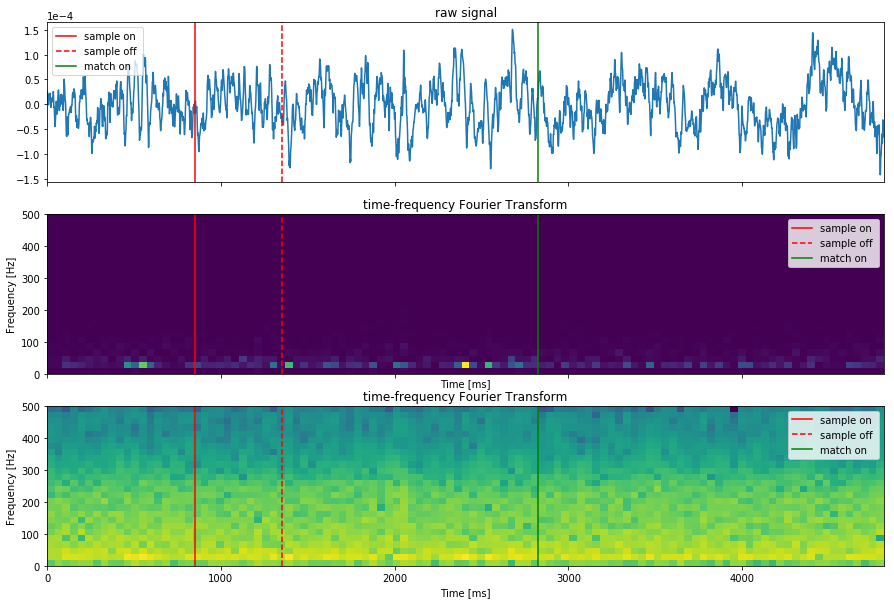

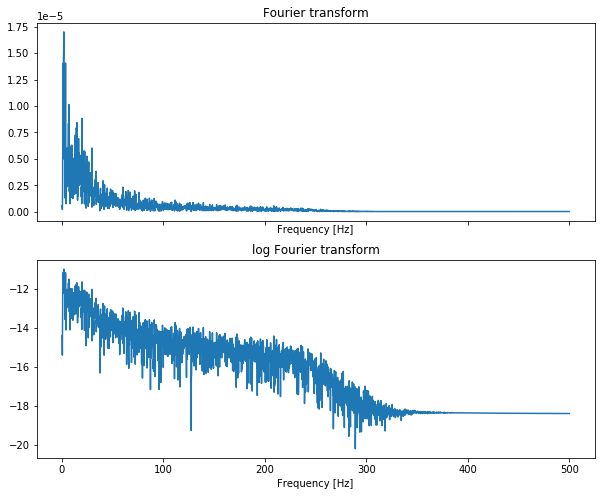

In [11]:
###################################################
# 
###################################################
sess_no  = '150128'#session[0]
n_trial_raw = 1 # start at 1
n_elec_raw = 0 

print(sess_no, n_trial_raw, n_elec_raw)
###################################################
# path
raw_path_sess_no = raw_path + sess_no +'/session01/' 
rinfo_path = raw_path_sess_no + 'recording_info.mat'
tinfo_path = raw_path_sess_no + 'trial_info.mat'

###################################################
#                 LOAD DATA                       #
###################################################

n_zeros = 4-len(str(n_trial_raw))
trial_str = '0' * n_zeros + str(n_trial_raw)  # fills leading 0s
file_in = sess_no + '01.' + trial_str + '.mat'

Y_raw = io.get_data(raw_path_sess_no + file_in) # shape = (n_chans, time)
# select channel
y_raw = Y_raw[n_elec_raw, :]


# get sample on /match on
time_sample_on = io.get_sample_on(tinfo_path)[n_trial_raw]
time_match_on = io.get_match_on(tinfo_path)[n_trial_raw]
# get ssampling rates
fs = io.get_sfreq(rinfo_path)

areas = io.get_area_names(rinfo_path)

###################################################
#                print something                  #
###################################################

print('session : ', sess_no)
print('trial   : ', n_trial_raw)
print('n_chans : ', n_elec_raw,'('+ areas[n_elec_raw]+')')

###################################################
#       plot raw signal and  STFT                 #
###################################################
# SUBPLOT
fig, axarr = plt.subplots(3, sharex=True, figsize=(15,10))

# plot raw signal
axarr[0].plot(y_raw)

# set scientific format for y axis
axarr[0].ticklabel_format(axis='y',style='sci', scilimits=(0,0))

# set title
#axarr[0].set_ylabel('raw signal')
axarr[0].set_title('raw signal')

# set sample on/off, match on 
axarr[0].axvline(x= time_sample_on, color='r',label='sample on ')
axarr[0].axvline(x= time_sample_on +500, color='r', linestyle='--', label='sample off') #sample off
axarr[0].axvline(x= time_match_on, color='green', label='match on ')
axarr[0].legend()



# Time-frequency transform (Spectogram)

window = ('tukey', 0.25)
nperseg = int(50)

f, t, Sxx = signal.spectrogram(y_raw, fs, window=window, nperseg=nperseg)
axarr[1].imshow(Sxx, extent=[0, len(y_raw), 0, max(f)], aspect='auto', origin='lower' )

axarr[1].set_ylabel('Frequency [Hz]')
axarr[1].set_xlabel('Time [ms]')
axarr[1].set_title('time-frequency Fourier Transform')

# set sample on/off, match on 
axarr[1].axvline(x= time_sample_on, color='r',label='sample on ')
axarr[1].axvline(x= time_sample_on +500, color='r', linestyle='--', label='sample off') #sample off
axarr[1].axvline(x= time_match_on, color='green', label='match on ')
axarr[1].legend()

#plot log STFT
axarr[2].imshow(np.log10(Sxx), extent=[0, len(y_raw), 0, max(f)], aspect='auto', origin='lower' )

axarr[2].set_ylabel('Frequency [Hz]')
axarr[2].set_xlabel('Time [ms]')
axarr[2].set_title('time-frequency Fourier Transform')

# set sample on/off, match on 
axarr[2].axvline(x= time_sample_on, color='r',label='sample on ')
axarr[2].axvline(x= time_sample_on +500, color='r', linestyle='--', label='sample off') #sample off
axarr[2].axvline(x= time_match_on, color='green', label='match on ')
axarr[2].legend()


plt.show()

###################################################
#            PLOT FOURIER TRANSFORM               #
###################################################

# subplot
fig, axarr = plt.subplots(2, sharex=True, figsize=(10,8))

# Number of samplepoints
N = len(y_raw)
# sample spacing
T = 1.0 / float(fs)

# fourier transform
xf = np.linspace(0.0, 1.0/(2.0*T), int(N/2))
yf = scipy.fftpack.fft(y_raw)

# plot it
axarr[0].plot(xf, 2.0/N * np.abs(yf[:int(N//2)]))

# scienctic format
axarr[0].ticklabel_format(axis='y',style='sci', scilimits=(0,0))

# set title and label
axarr[0].set_title('Fourier transform')
axarr[0].set_xlabel('Frequency [Hz]')

# plot with log
axarr[1].plot(xf, np.log(2.0/N) + np.log(np.abs(yf[:int(N//2)])))

plt.title('log Fourier transform')
plt.xlabel('Frequency [Hz]')

plt.show()


# filtered signal + raw signal

session :  150210
trial   :  1
n_chans :  0 (a46V)


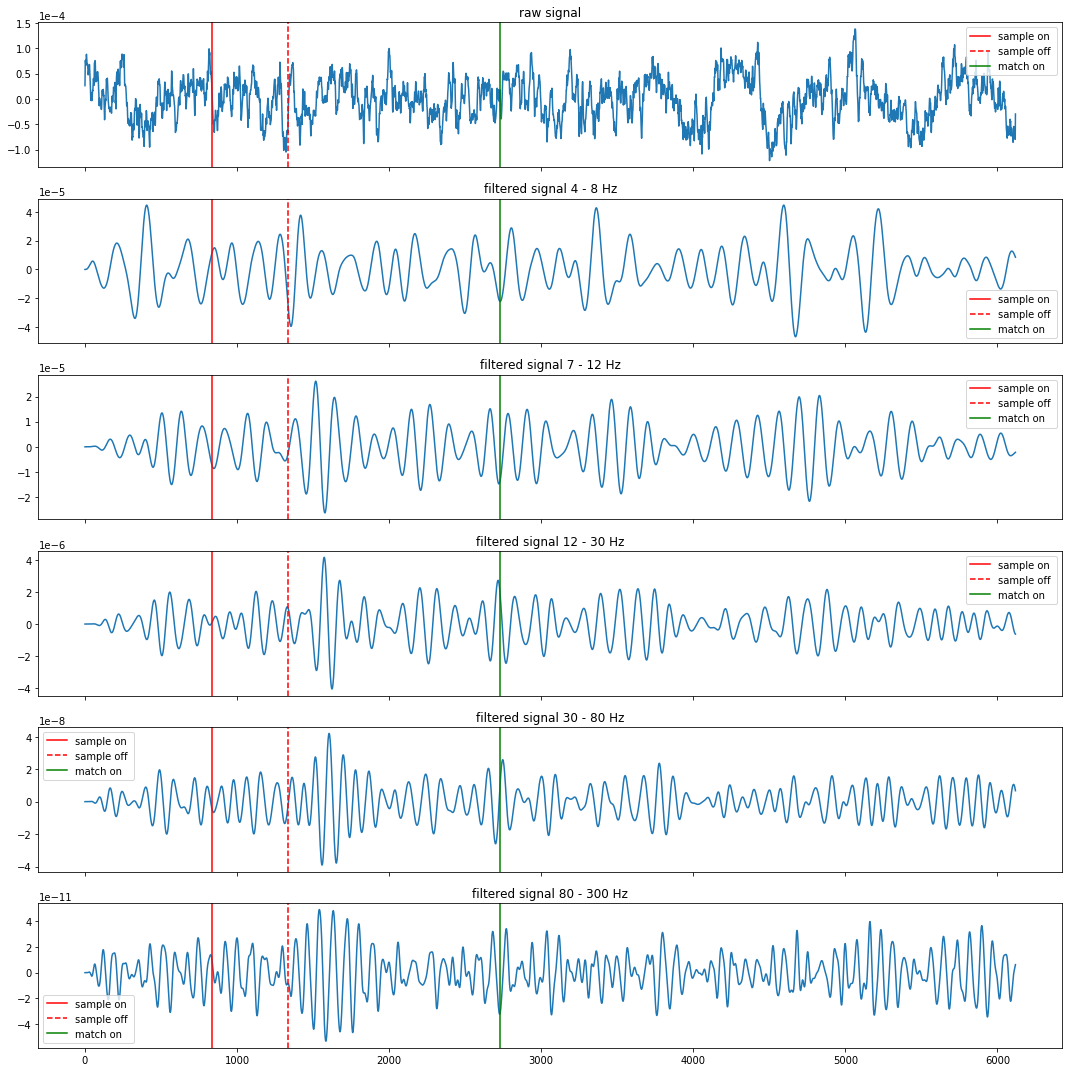

In [12]:
# LOAD RAW DATA
sess_no  = session[0]
n_trial_raw = 1 # start at 1
n_elec_raw = 0 

# path
raw_path_sess_no = raw_path + sess_no +'/session01/' 
rinfo_path = raw_path_sess_no + 'recording_info.mat'
tinfo_path = raw_path_sess_no + 'trial_info.mat'

# sample on /match on
time_sample_on = io.get_sample_on(tinfo_path)[n_trial_raw]
time_match_on = io.get_match_on(tinfo_path)[n_trial_raw]
# samples rates
srate = io.get_sfreq(rinfo_path)
# area names
areas = io.get_area_names(rinfo_path)


print('session : ', sess_no)
print('trial   : ', n_trial_raw)
print('n_chans : ', n_elec_raw,'('+ areas[n_elec_raw]+')')



# load data
n_zeros = 4-len(str(n_trial_raw))
trial_str = '0' * n_zeros + str(n_trial_raw)  # fills leading 0s
file_in = sess_no + '01.' + trial_str + '.mat'

Y_raw = io.get_data(raw_path_sess_no + file_in) # np array 62 * 5660 
#select channel
# areas = io.get_area_names(rinfo_path)
y_raw = Y_raw[n_elec_raw, :]


# PLOT SIGNAL 
#subplot, share axis, figsize
fig, axarr = plt.subplots(6, sharex=True, figsize=(15,15))

# plot raw signal
axarr[0].plot(y_raw)

# set scientific format for y axis
axarr[0].ticklabel_format(axis='y',style='sci', scilimits=(0,0))

# set title
#axarr[0].set_ylabel('raw signal')
axarr[0].set_title('raw signal')

# set sample on/off, match on 
axarr[0].axvline(x= time_sample_on, color='r',label='sample on ')
axarr[0].axvline(x= time_sample_on +500, color='r', linestyle='--', label='sample off') #sample off
axarr[0].axvline(x= time_match_on, color='green', label='match on ')
axarr[0].legend()

#plt.show()

count = 0
for lowcut, highcut, order in [[4,8,3],
                               [7,12,3],
                               [12,30,3],
                               [30,80,3],
                               [80,300,3]]:
    count+=1
    
    Y_raw = pp.butter_bandpass_filter(Y_raw, lowcut, highcut, srate, order=3)
    y_raw = Y_raw[n_elec_raw, :]

    axarr[count].plot(y_raw)
    
    axarr[count].ticklabel_format(axis='y',style='sci', scilimits=(0,0))
    
    axarr[count].set_title('filtered signal '+str(lowcut)+ ' - ' +str(highcut) +' Hz')
    

    axarr[count].axvline(x= time_sample_on, color='r',label='sample on ')
    axarr[count].axvline(x= time_sample_on +500, color='r', linestyle='--', label='sample off') #sample off
    axarr[count].axvline(x= time_match_on, color='green', label='match on ')
    axarr[count].legend()


fig.tight_layout()
plt.show()



# TF et  potenciel évoqué

# load data

In [13]:
# sess
sess_no = '150210' # '150128'

In [14]:
# path 
raw_path_sess_no = raw_path + sess_no +'/session01/' 
rinfo_path = raw_path_sess_no + 'recording_info.mat'
tinfo_path = raw_path_sess_no + 'trial_info.mat'

In [15]:
align_on = 'sample'
from_time = - 800
to_time = 500 + 1000 + 2000

In [16]:
data = get_cut_from_raw(sess_no, raw_path+sess_no+'/session01/', 'sample', from_time, to_time)

15021001.0001.mat
15021001.0002.mat
15021001.0003.mat
15021001.0004.mat
15021001.0005.mat
15021001.0006.mat
15021001.0007.mat
15021001.0008.mat
15021001.0009.mat
15021001.0010.mat
15021001.0011.mat
15021001.0012.mat
15021001.0013.mat
15021001.0014.mat
15021001.0015.mat
15021001.0016.mat
15021001.0017.mat
15021001.0018.mat
15021001.0019.mat
15021001.0020.mat
15021001.0021.mat
15021001.0022.mat
15021001.0023.mat
15021001.0024.mat
15021001.0025.mat
15021001.0026.mat
15021001.0027.mat
15021001.0028.mat
15021001.0029.mat
15021001.0030.mat
15021001.0031.mat
15021001.0032.mat
15021001.0033.mat
15021001.0034.mat
15021001.0035.mat
15021001.0036.mat
15021001.0037.mat
15021001.0038.mat
15021001.0039.mat
15021001.0040.mat
15021001.0041.mat
15021001.0042.mat
15021001.0043.mat
15021001.0044.mat
15021001.0045.mat
15021001.0046.mat
15021001.0047.mat
15021001.0048.mat
15021001.0049.mat
15021001.0050.mat
15021001.0051.mat
15021001.0052.mat
15021001.0053.mat
15021001.0054.mat
15021001.0055.mat
15021001.0

15021001.0452.mat
15021001.0453.mat
15021001.0454.mat
15021001.0455.mat
15021001.0456.mat
15021001.0457.mat
15021001.0458.mat
15021001.0459.mat
15021001.0460.mat
15021001.0461.mat
15021001.0462.mat
15021001.0463.mat
15021001.0464.mat
15021001.0465.mat
15021001.0466.mat
15021001.0467.mat
15021001.0468.mat
15021001.0469.mat
15021001.0470.mat
15021001.0471.mat
15021001.0472.mat
15021001.0473.mat
15021001.0474.mat
15021001.0475.mat
15021001.0476.mat
15021001.0477.mat
15021001.0478.mat
15021001.0479.mat
15021001.0480.mat
15021001.0481.mat
15021001.0482.mat
15021001.0483.mat
15021001.0484.mat
15021001.0485.mat
15021001.0486.mat
15021001.0487.mat
15021001.0488.mat
15021001.0489.mat
15021001.0490.mat
15021001.0491.mat
15021001.0492.mat
15021001.0493.mat
15021001.0494.mat
15021001.0495.mat
15021001.0496.mat
15021001.0497.mat
15021001.0498.mat
15021001.0499.mat
15021001.0500.mat
15021001.0501.mat
15021001.0502.mat
15021001.0503.mat
15021001.0504.mat
15021001.0505.mat
15021001.0506.mat
15021001.0

15021001.0906.mat
15021001.0907.mat
15021001.0908.mat
15021001.0909.mat
15021001.0910.mat
15021001.0911.mat
15021001.0912.mat
15021001.0913.mat
15021001.0914.mat
15021001.0915.mat
15021001.0916.mat
15021001.0917.mat
15021001.0918.mat
15021001.0919.mat
15021001.0920.mat
15021001.0921.mat
15021001.0922.mat
15021001.0923.mat
15021001.0924.mat
15021001.0925.mat
15021001.0926.mat
15021001.0927.mat
15021001.0928.mat
15021001.0929.mat
15021001.0930.mat
15021001.0931.mat
15021001.0932.mat
15021001.0933.mat
15021001.0934.mat
15021001.0935.mat
15021001.0936.mat
15021001.0937.mat
15021001.0938.mat
15021001.0939.mat
15021001.0940.mat
15021001.0941.mat
15021001.0942.mat
15021001.0943.mat
15021001.0944.mat
15021001.0945.mat
15021001.0946.mat
15021001.0947.mat
15021001.0948.mat
15021001.0949.mat
15021001.0950.mat
15021001.0951.mat
15021001.0952.mat
15021001.0953.mat
15021001.0954.mat
15021001.0955.mat
15021001.0956.mat
15021001.0957.mat
15021001.0958.mat
15021001.0959.mat
15021001.0960.mat
15021001.0

In [17]:
area_names = io.get_area_names(rinfo_path)

In [18]:
fs = io.get_sfreq(rinfo_path)

In [19]:
area_names.shape

(78,)

In [20]:
data.shape

(1015, 78, 4300)

# select channel if wanted

In [ ]:
# # Select some cortex  ?
# target_cortex = ['Visual'] # [cortex1, cortex2]
# dico_area_to_cortex = io.get_dico_area_to_cortex()
# ind_to_keep = []
# for idx, area in enuemrate(area_names):
#     if dico_area_to_cortex[area] in target_cortex :
#         ind_to_keep.append(idx)
        
# data = data[:,ind_to_keep,:]
# area_names = area_names[ind_to_keep]
        

In [ ]:
# # select some areas ?
# target_areas = ['V1'] # [area1, area2]
# dico_area_to_cortex = io.get_dico_area_to_cortex()
# ind_to_keep = []
# for idx, area in enuemrate(area_names):
#     if area in target_areas :
#         ind_to_keep.append(idx)
        
# data = data[:,ind_to_keep,:]
# area_names = area_names[ind_to_keep]

# some stuff

In [21]:
data.mean()

-1.5215747847945095e-07

In [22]:
data.std()

7.131968375399037e-05

In [23]:
np.sqrt((data**2).mean())

7.131984606452442e-05

In [25]:
power_by_channel = np.sqrt(np.mean(data**2, axis=(0,2)))

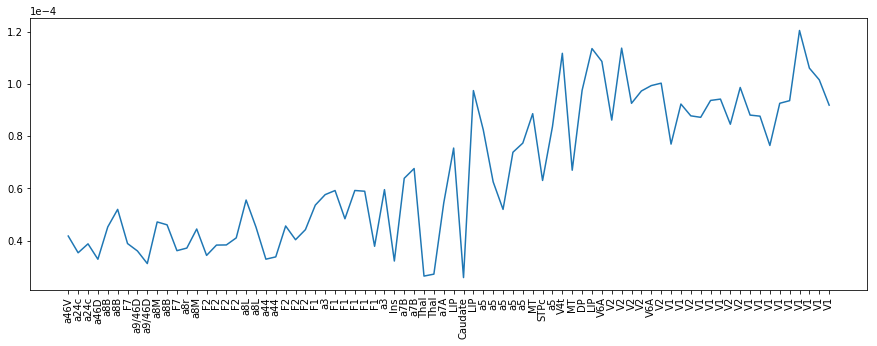

In [28]:
plt.figure(figsize=(15,5))
plt.plot( power_by_channel )
plt.xticks(np.arange(len(area_names)), area_names, rotation='vertical')
plt.ticklabel_format(axis='y',style='sci', scilimits=(0,0))
plt.title('Signal power')
plt.show()

# mean on abs( ft )

In [29]:
# Number of samplepoints
N = data.shape[2]
# sample spacing
#T = 1.0 / 1000.0
T = 1.0 / float(fs) # fs = 1000

xf = np.linspace(0.0, 1.0/(2.0*T), int(N/2))

tf = []
for n in range(data.shape[0]):
    for j in range(data.shape[1]):
        yf = scipy.fftpack.fft(data[n,j,:])
        tf.append( 2.0/N * np.abs(yf[:int(N//2)] ) )

tf = np.array(tf)

tf = np.mean(tf, axis=0)

In [30]:
tf.shape

(2150,)

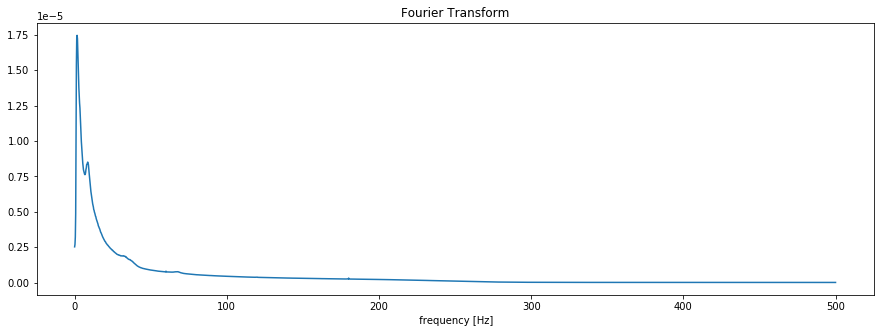

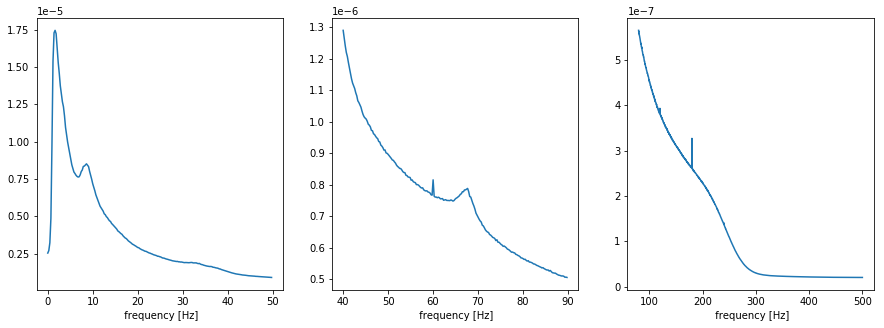

In [31]:
# plot fourier transform
plt.figure(figsize=(15,5))
plt.plot(xf, tf)
plt.title('Fourier Transform')
plt.xlabel(' frequency [Hz]')
plt.ticklabel_format(axis='y',style='sci', scilimits=(0,0))

plt.show()

# plot some frequency band with different scale 
plt.figure(figsize=(15,5))

# 0 to 50 Hz
fmax = 50
ind_max = int( xf.shape[0] * fmax/(fs/2) )
plt.subplot(131)
plt.plot(xf[:ind_max], tf[:ind_max])
plt.ticklabel_format(axis='y',style='sci', scilimits=(0,0))
plt.xlabel(' frequency [Hz]')

# 40 to 90 Hz
plt.subplot(132)
fmin = 40
fmax = 90
ind_min = int( xf.shape[0] * fmin/(fs/2) )
ind_max = int( xf.shape[0] * fmax/(fs/2) )
plt.plot(xf[ind_min:ind_max], tf[ind_min:ind_max])
plt.ticklabel_format(axis='y',style='sci', scilimits=(0,0))
plt.xlabel(' frequency [Hz]')

# 80 to 500 Hz
plt.subplot(133)
fmin = 80
ind_min = int( xf.shape[0] * fmin/(fs/2) )
plt.plot(xf[ind_min:], tf[ind_min:])
plt.ticklabel_format(axis='y',style='sci', scilimits=(0,0))
plt.xlabel(' frequency [Hz]')


plt.show()

# potenciel évoqué

In [ ]:
# # filter data ?
# lowcut, highcut = 7, 12 
# data = pp.butter_bandpass_filter(Y_raw, lowcut, highcut, srate, order=3)

In [35]:
potenciel = np.mean(data, axis= 0)

In [36]:
potenciel.shape

(78, 4300)

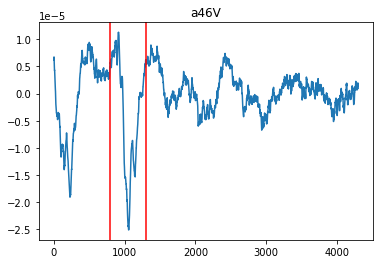

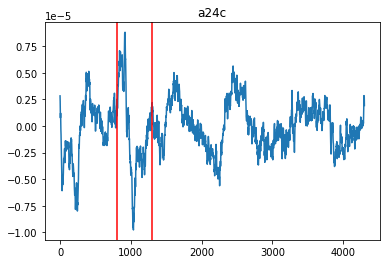

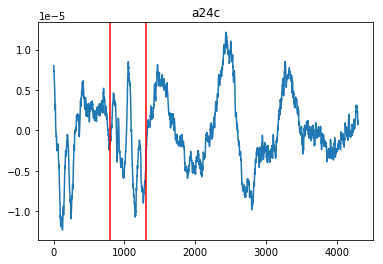

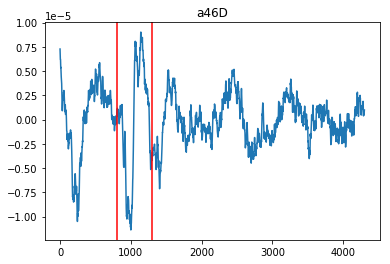

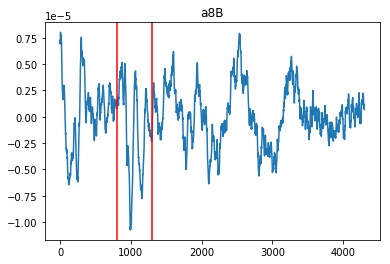

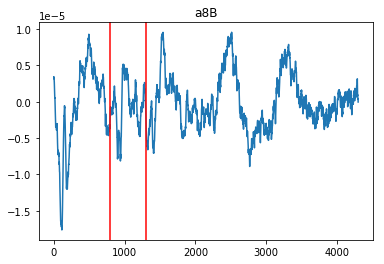

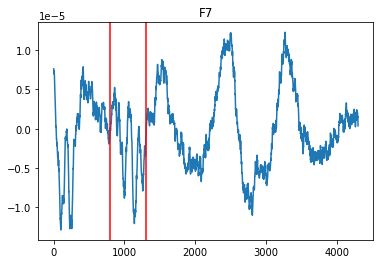

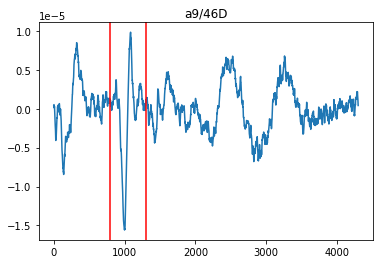

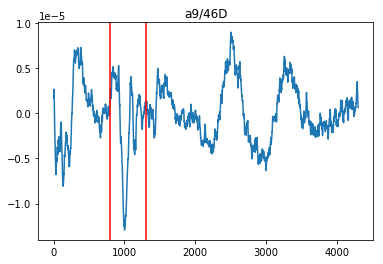

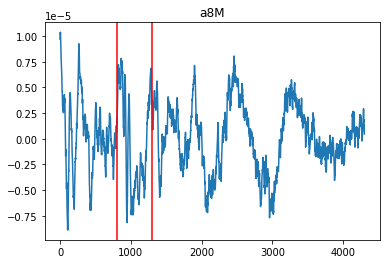

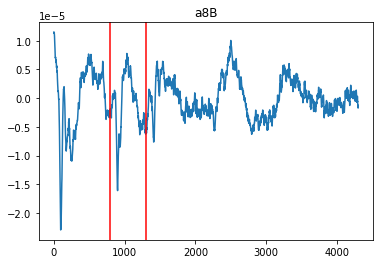

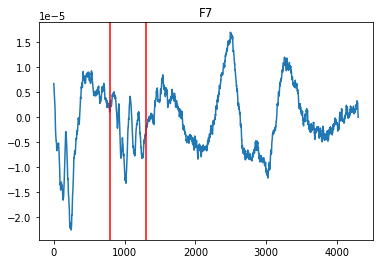

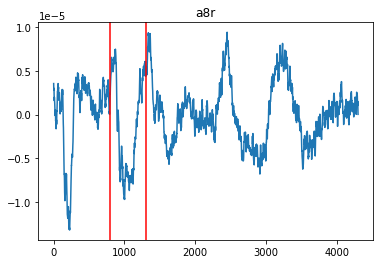

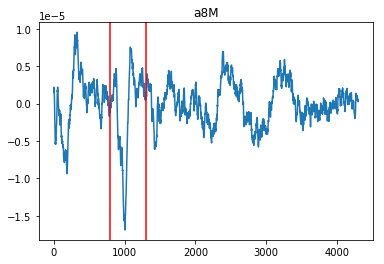

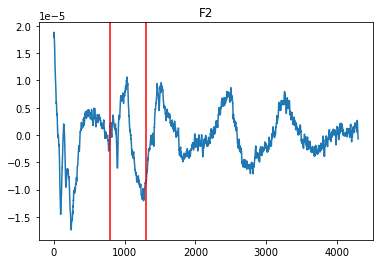

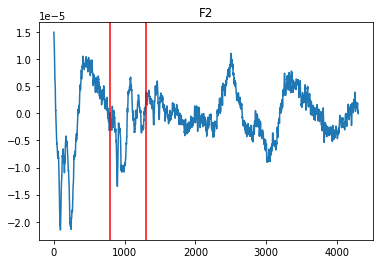

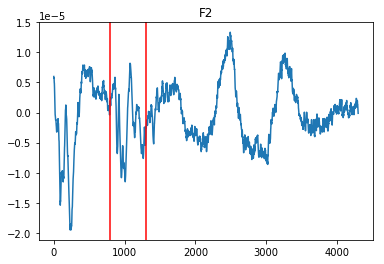

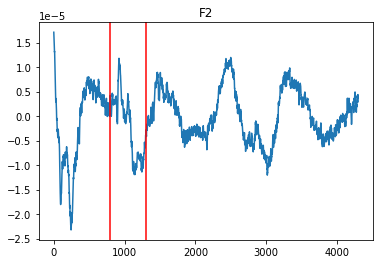

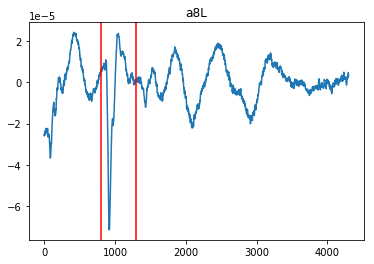

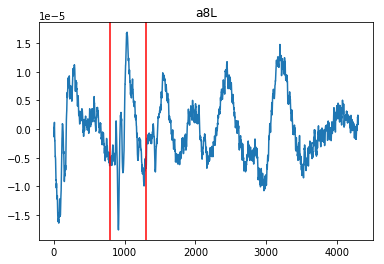

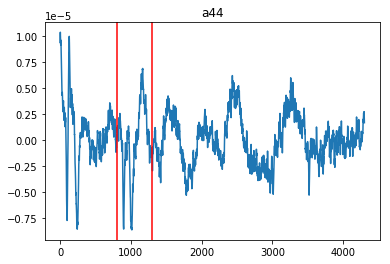

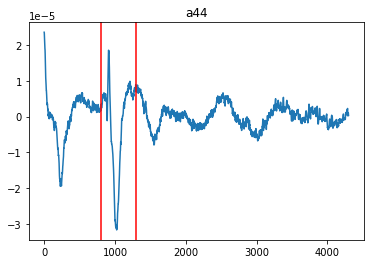

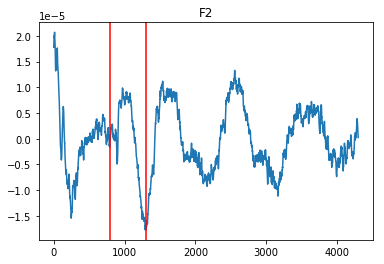

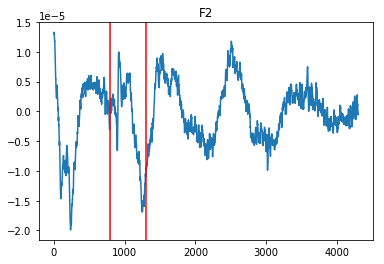

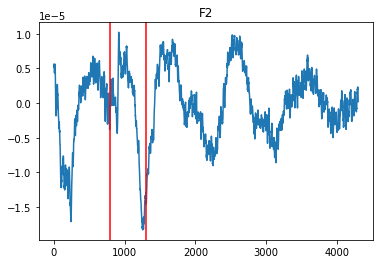

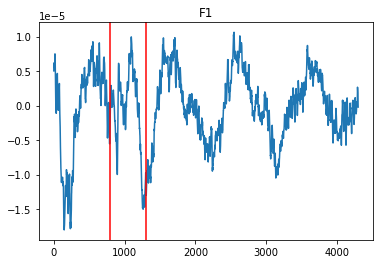

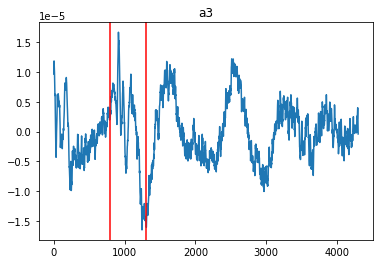

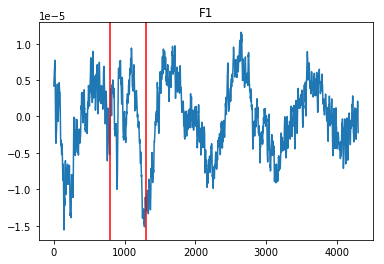

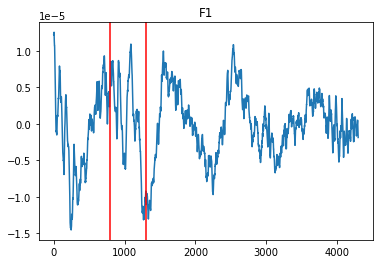

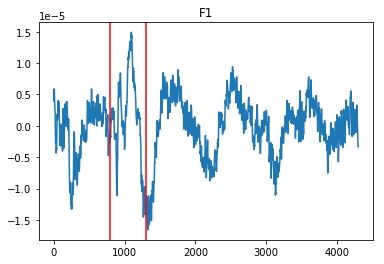

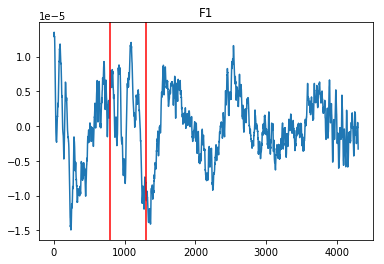

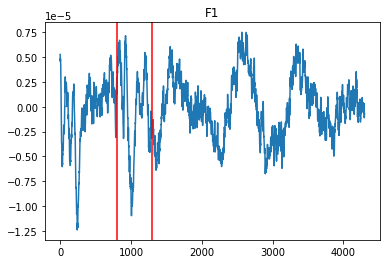

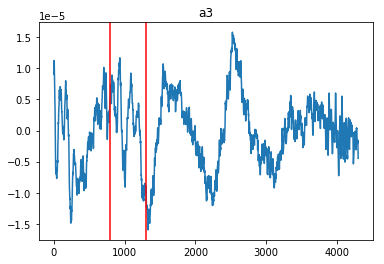

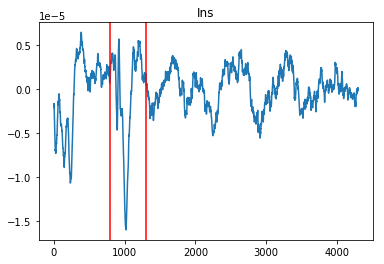

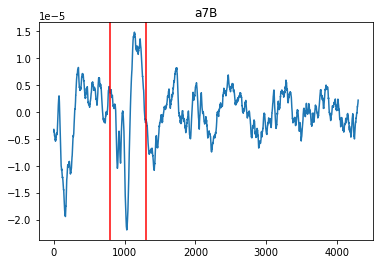

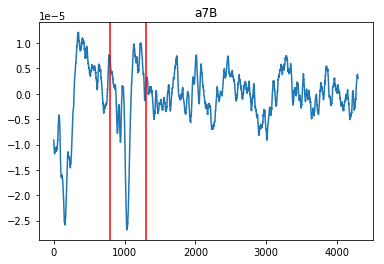

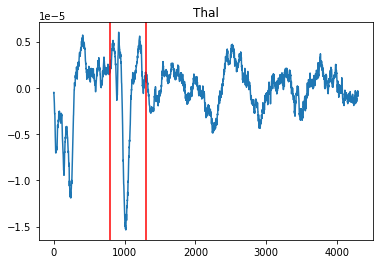

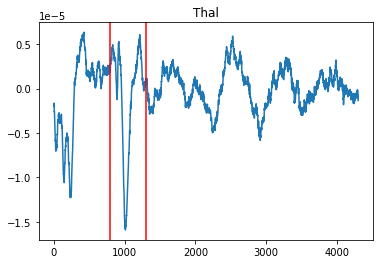

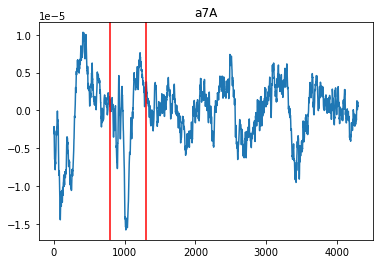

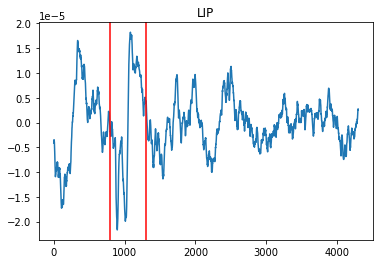

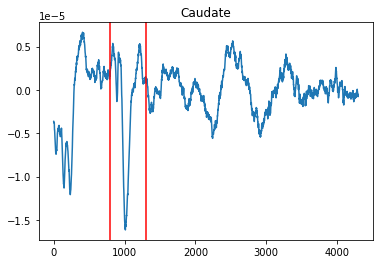

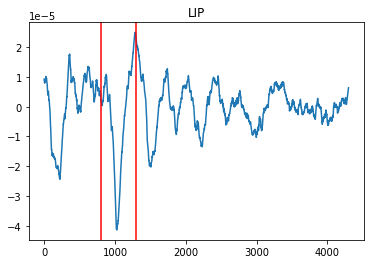

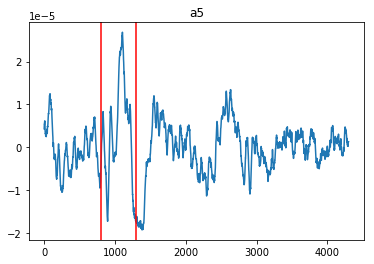

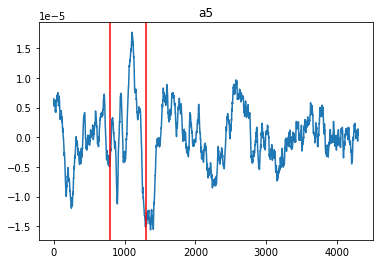

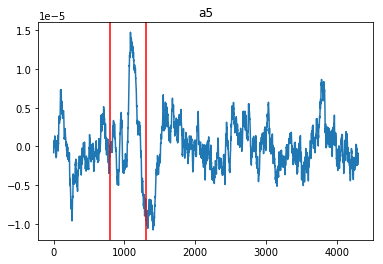

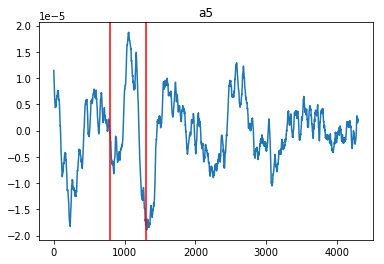

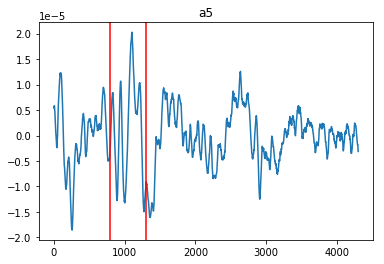

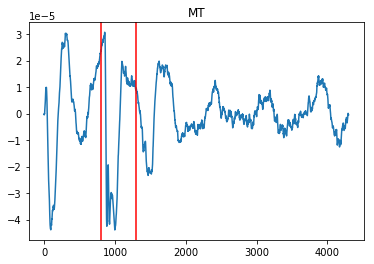

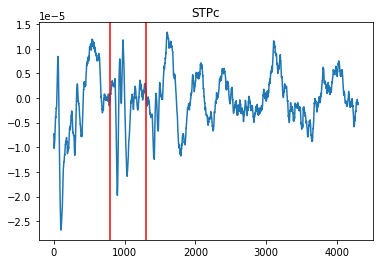

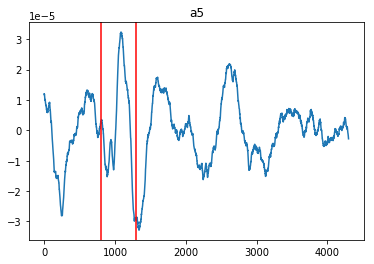

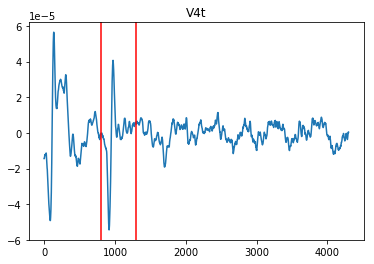

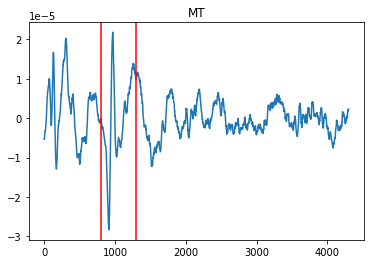

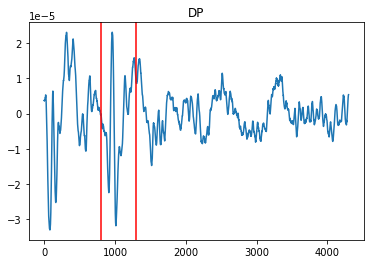

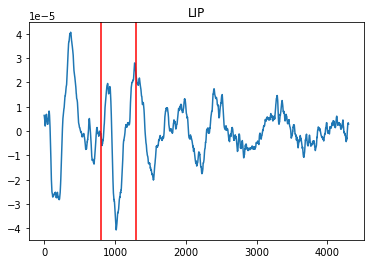

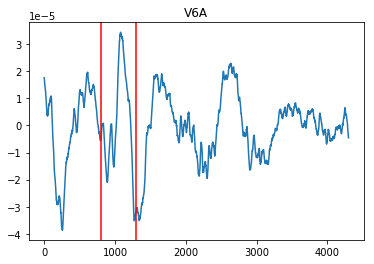

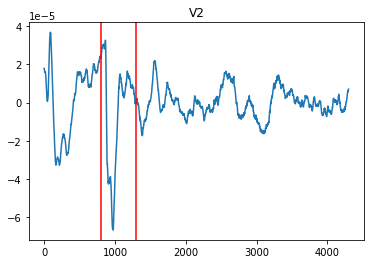

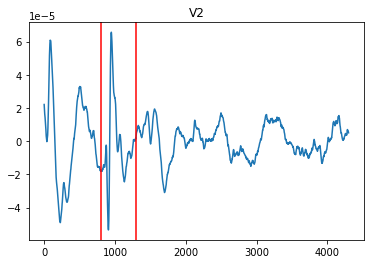

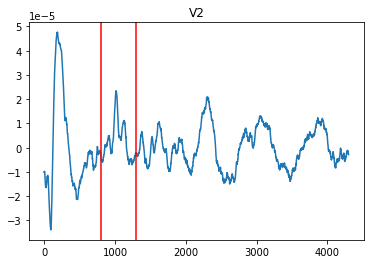

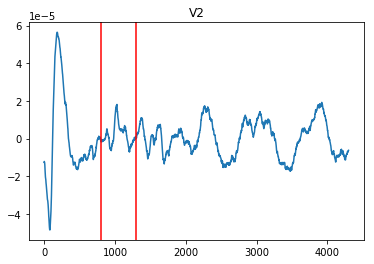

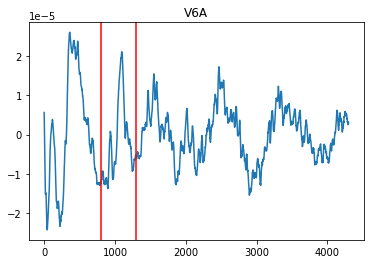

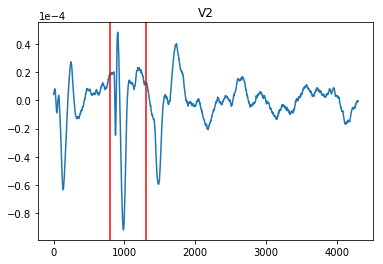

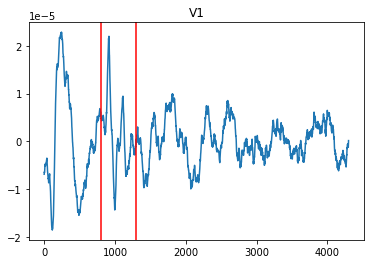

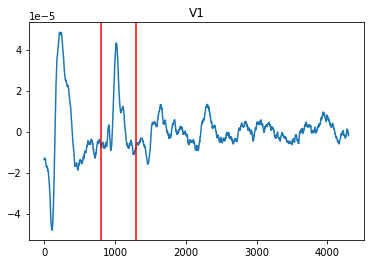

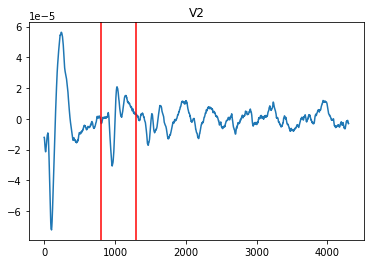

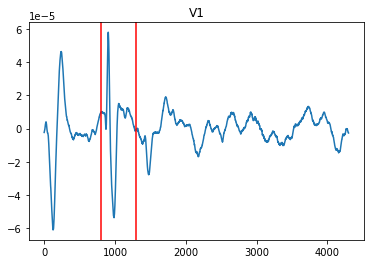

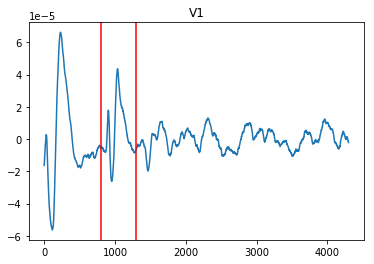

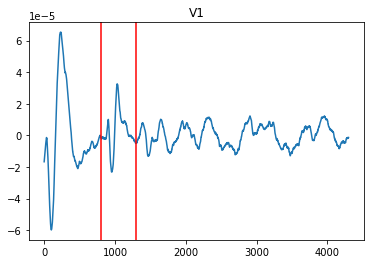

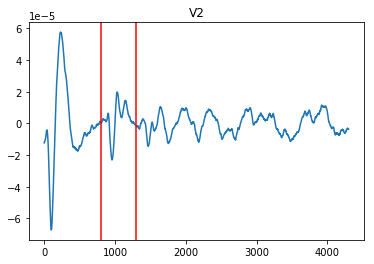

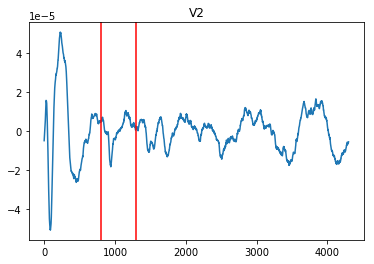

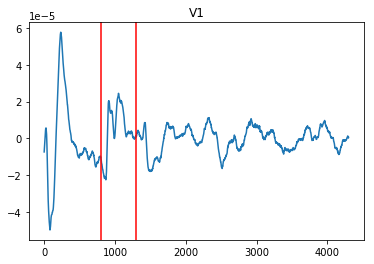

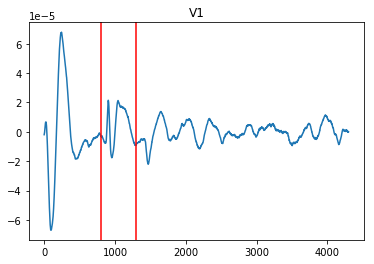

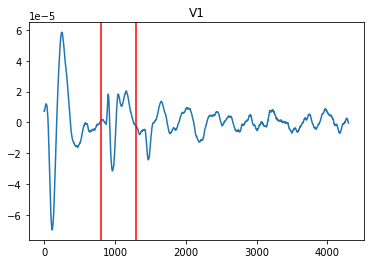

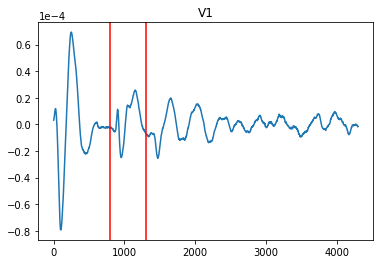

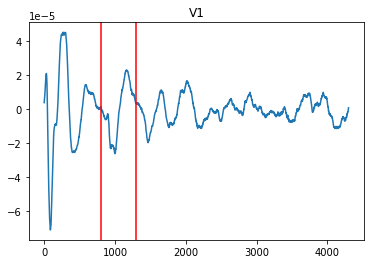

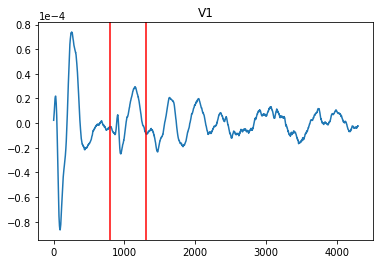

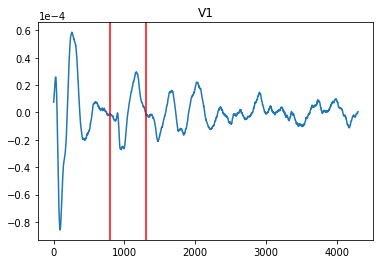

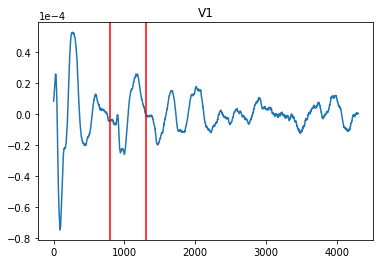

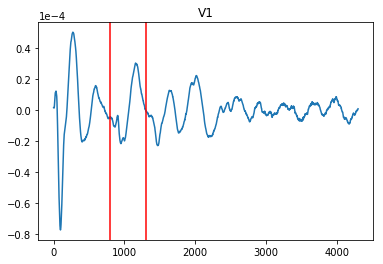

In [37]:
for i in range(potenciel.shape[0]):
    plt.plot(potenciel[i,:])
    plt.ticklabel_format(axis='y',style='sci', scilimits=(0,0))
    plt.title(area_names[i])
    plt.axvline(x= -from_time , color='r', label='sample on')
    plt.axvline(x= -from_time + 500, color='r', label='sample off')
    plt.show()